# Cold War Simulation Analysis
## Experiment 4 -- New model, 1948 COW data

In [1]:
import copy
import pickle
import random
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations
import os

import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

# Loading original data

In [2]:
model_data = pd.read_csv("ColdWarActors_1948.csv")
#model_data.Position = (model_data.Position + 100)/200

In [3]:
model_data.head()

,Unnamed: 0,Capability,Country,Position
0,0,0.294660,United States of America,1.000000e+00
1,1,0.164000,Russia,-3.439353e-16
2,2,0.115055,China,5.724034e-01
3,3,0.075426,United Kingdom,5.368582e-01
4,4,0.052450,India,5.632982e-01


# Data serialization

In [4]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

In [5]:
with open("data_output/ColdWar_Experiment4_2.pickle", "rb") as f:
    model_runs = pickle.load(f)

In [6]:
len(model_runs)

1000

# Analyzing median positions

In [7]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.model_vars.copy()
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Step"}, inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
results = pd.concat(all_dfs)

In [8]:
results.tail()

,Step,Mean,Median,Iteration
20,20,0.556160,0.562771,999
21,21,0.552220,0.555878,999
22,22,0.560821,0.562771,999
23,23,0.557091,0.552389,999
24,24,0.563304,0.563298,999


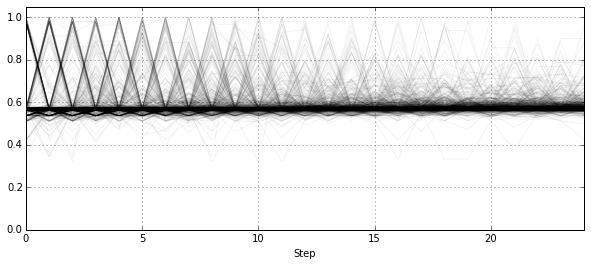

In [9]:
# Plot all runs
fig, ax = plt.subplots(figsize=(10, 4))
for i, group in results.groupby("Iteration"):
    group.plot(x="Step", y="Median", color='k', alpha=0.05, ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.grid(True)

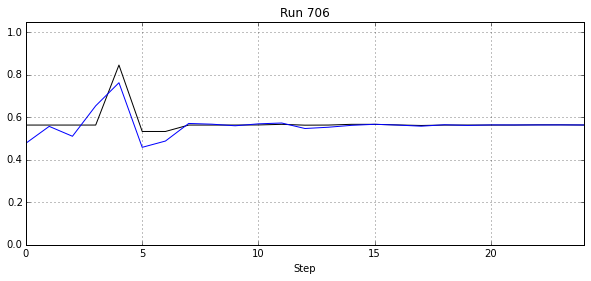

In [10]:
# Pick one trace at random
fig, ax = plt.subplots(figsize=(10, 4))
i = random.randint(0, 999)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

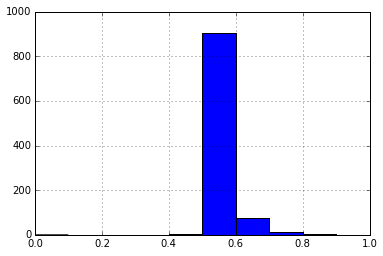

In [11]:
results[results.Step==24]["Median"].hist(bins=np.linspace(0, 1, 11))

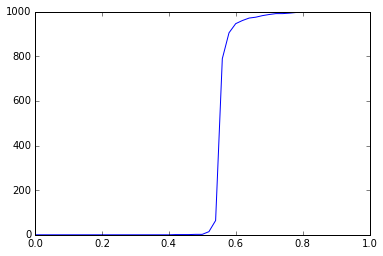

In [12]:
values, base = np.histogram(results[results.Step==24]["Median"], bins=np.linspace(0,1,51))
cdf = np.cumsum(values)
plt.plot(base[:-1], cdf)

In [13]:
import pyobjclipboard
pyobjclipboard.copy_object((base, cdf))

**Look at only runs where the US "wins".**

In [14]:
# Get iterations where US wins
us_win = results[(results.Step==24) & (results.Median>0.8)]["Iteration"].unique()

In [15]:
len(us_win)

4

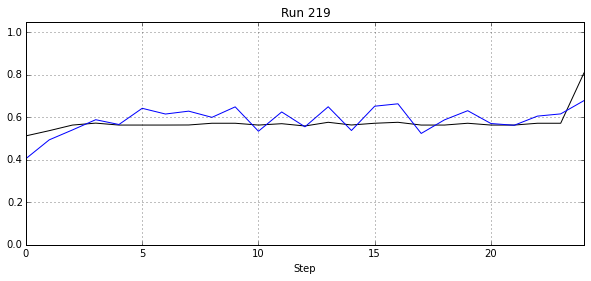

In [16]:
# Plot a random US victory
fig, ax = plt.subplots(figsize=(10, 4))
i = random.choice(us_win)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

In [17]:
ussr_win = results[(results.Step==24) & (results.Median<0.2)]["Iteration"].unique()

In [18]:
len(ussr_win)

0

## Deep dive into one run

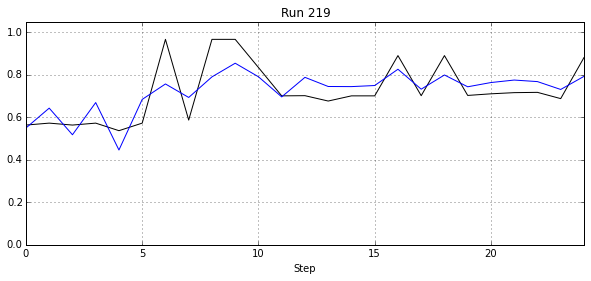

In [19]:
run_choice = 127
fig, ax = plt.subplots(figsize=(10, 4))
subset = results[results.Iteration==run_choice]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

In [20]:
m = model_runs[run_choice]

In [21]:
agent_positions = m.agent_vars.copy()
agent_positions.reset_index(inplace=True)

(0, 1.05)

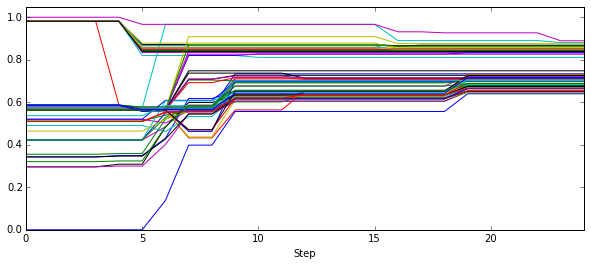

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, group in agent_positions.groupby("AgentID"):
    group.plot(x="Step", y="Position", ax=ax, legend=False)

ax.set_ylim(0, 1.05)

In [23]:
m.log.get_events(action="Attack")

[Event(source='United States of America', target='Russia', timestamp=0, action='Attack'),
 Event(source='Russia', target='United States of America', timestamp=0, action='Attack'),
 Event(source='United States of America', target='Russia', timestamp=1, action='Attack'),
 Event(source='Russia', target='United States of America', timestamp=1, action='Attack'),
 Event(source='United States of America', target='Russia', timestamp=2, action='Attack'),
 Event(source='Russia', target='United States of America', timestamp=2, action='Attack'),
 Event(source='Brazil', target='Yugoslavia', timestamp=2, action='Attack'),
 Event(source='Yugoslavia', target='Brazil', timestamp=2, action='Attack'),
 Event(source='United States of America', target='Russia', timestamp=3, action='Attack'),
 Event(source='Russia', target='United States of America', timestamp=3, action='Attack'),
 Event(source='United States of America', target='Russia', timestamp=7, action='Attack'),
 Event(source='Russia', target='United

In [24]:
# Average unweighted postion

In [25]:
average_position = agent_positions.groupby("Step").aggregate("mean")

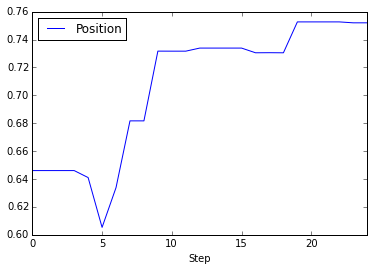

In [26]:
average_position.plot()

# Agent position analysis

In [27]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.agent_vars.copy()
    df.reset_index(inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
agent_positions = pd.concat(all_dfs)

In [28]:
len(agent_positions.AgentID.unique())

72

## How far do agents end up from their starting position?

In [29]:
end_positions = agent_positions[agent_positions.Step==24]\
    .groupby("AgentID")["Position"].aggregate([np.mean, np.std])

end_positions = end_positions.rename(columns={"mean": "EndPos_mean",
                             "std": "EndPos_std"})

In [30]:
end_positions = end_positions.merge(model_data, left_index=True, right_on="Country")

In [31]:
end_positions.EndPos_std.mean()

0.035883021240013233

In [32]:
end_positions["Delta"] = end_positions.EndPos_mean - end_positions.Position

-0.0665729695134
-0.383688869856
0.545006383519


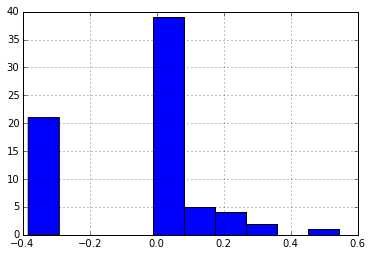

In [33]:
print(end_positions.Delta.mean())
print(end_positions.Delta.min())
print(end_positions.Delta.max())
end_positions.Delta.hist()

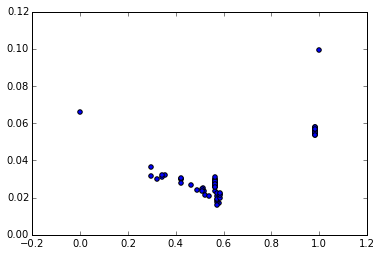

In [34]:
plt.scatter(end_positions.Position, end_positions.EndPos_std)

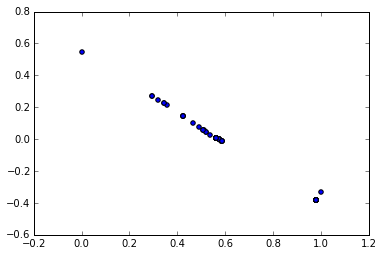

In [35]:
plt.scatter(end_positions.Position, end_positions.Delta)

In [36]:
end_positions.corr()

,EndPos_mean,EndPos_std,Unnamed: 0,Capability,Position,Delta
EndPos_mean,1.000000,0.837660,0.232318,0.310074,0.868996,-0.849628
EndPos_std,0.837660,1.000000,0.115084,0.396402,0.691569,-0.672954
Unnamed: 0,0.232318,0.115084,1.000000,-0.473726,0.423067,-0.433123
Capability,0.310074,0.396402,-0.473726,1.000000,-0.073450,0.102020
Position,0.868996,0.691569,0.423067,-0.073450,1.000000,-0.999282
Delta,-0.849628,-0.672954,-0.433123,0.102020,-0.999282,1.000000


In [37]:
end_positions.corr(method='spearman')

,EndPos_mean,EndPos_std,Unnamed: 0,Capability,Position,Delta
EndPos_mean,1.000000,0.477072,0.379510,-0.379510,0.940947,-0.856647
EndPos_std,0.477072,1.000000,0.079909,-0.079909,0.359091,-0.311210
Unnamed: 0,0.379510,0.079909,1.000000,-1.000000,0.436816,-0.503730
Capability,-0.379510,-0.079909,-1.000000,1.000000,-0.436816,0.503730
Position,0.940947,0.359091,0.436816,-0.436816,1.000000,-0.969260
Delta,-0.856647,-0.311210,-0.503730,0.503730,-0.969260,1.000000


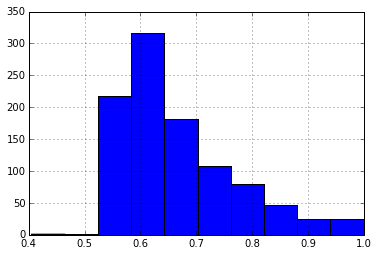

In [38]:
agent_positions[(agent_positions.AgentID=="United States of America") & 
                (agent_positions.Step==24)]["Position"].hist()

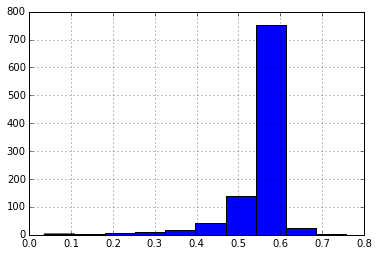

In [39]:
agent_positions[(agent_positions.AgentID=="Russia") & 
                (agent_positions.Step==24)]["Position"].hist()

# Conflict frequencies

In [40]:
actors = model_data.Country.unique()

In [41]:
model.model_vars.Median[24]

0.56329822578208133

In [42]:
conflict_dyads = Counter()
conflict_models = defaultdict(set)

for i, model in enumerate(model_runs):
    if model.model_vars.Median[24] < 0.75:
        continue
    for event in model.log.get_events(action="Attack"):
        if event.timestamp > 25: # Max steps to consider
            continue
        source = event.source
        target = event.target
        dyad = (source, target)
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        conflict_dyads[dyad] += 0.5
        conflict_models[dyad].add(i)

conflict_models = {k: len(v) for k, v in conflict_models.items()}        
        
# Fill in zeroes
for source, target in permutations(actors, 2):
    dyad = (source, target)
    if (target, source) in conflict_dyads:
        dyad = (target, source)
    if dyad not in conflict_dyads:
        conflict_dyads[dyad] = 0
    if dyad not in conflict_models:
        conflict_models[dyad] = 0

In [43]:
conflict_dyads.most_common(20)

[(('United States of America', 'Russia'), 51.0),
 (('United States of America', 'United Kingdom'), 9.0),
 (('Russia', 'Argentina'), 7.0),
 (('United States of America', 'India'), 5.0),
 (('United States of America', 'Yugoslavia'), 5.0),
 (('United States of America', 'China'), 4.0),
 (('United States of America', 'Czechoslovakia'), 4.0),
 (('Russia', 'China'), 3.0),
 (('United States of America', 'Poland'), 3.0),
 (('United States of America', 'Portugal'), 3.0),
 (('China', 'India'), 3.0),
 (('China', 'France'), 3.0),
 (('United States of America', 'Guatemala'), 2.0),
 (('China', 'United Kingdom'), 2.0),
 (('Russia', 'Uruguay'), 2.0),
 (('India', 'Poland'), 2.0),
 (('United Kingdom', 'France'), 2.0),
 (('Russia', 'Ecuador'), 2.0),
 (('United Kingdom', 'India'), 2.0),
 (('Russia', 'India'), 2.0)]

## Load MID data

In [44]:
COW = "/Users/dmasad/Data/COW/"
mid_a = pd.read_csv(COW + "MIDA_4.01.csv")
mid_b = pd.read_csv(COW + "MIDB_4.01.csv")

In [45]:
start_year = 1948
end_year = 1998
#end_year = 1948 + 5

mid_a = mid_a[(mid_a.StYear >= start_year) & (mid_a.StYear <= end_year)]
mid_b = mid_b[(mid_b.StYear >= start_year) & (mid_b.StYear <= end_year)]

### Get state names

In [46]:
state_names = pd.read_csv(COW + "SystemMembership2011/states2011.csv")
#state_names = state_names[["stateabb", "statenme"]]
state_names = state_names[["ccode", "statenme"]]
state_names.drop_duplicates(inplace=True)

In [47]:
name_dict = state_names.set_index("statenme").to_dict()["ccode"]

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [48]:
for name in model_data.Country.unique():
    if name not in name_dict:
        print(name)

In [49]:
#mid_b2 = mid_b.merge(state_names, how="left", left_on="ccode", right_on="stateabb")
mid_b = mid_b.merge(state_names, how="left", on="ccode")

In [50]:
observed_mids = defaultdict(int)
for dispnum, group in mid_b.groupby("DispNum3"):
    sides = {}
    for side, rows in group.groupby("SideA"):
        sides[side] = rows.statenme.unique()
    # Build dyads
    for side_a in sides[0]:
        for side_b in sides[1]:
            observed_mids[(side_a, side_b)] += 1
            observed_mids[(side_b, side_a)] += 1
observed_mids = dict(observed_mids)

In [51]:
observed_mids = pd.DataFrame({"Observed_MIDs": observed_mids})
observed_mids.reset_index(inplace=True)
observed_mids.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

### Merge

In [86]:
predicted_conflicts = pd.DataFrame({"Predicted_Conflicts": dict(conflict_dyads)})
predicted_conflicts.reset_index(inplace=True)
predicted_conflicts.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

In [87]:
conflicts = predicted_conflicts.merge(observed_mids, 'left', 
                                      on=["Source_Country", "Target_Country"])
conflicts.fillna(0, inplace=True)

In [88]:
conflicts.Predicted_Conflicts /= 1000

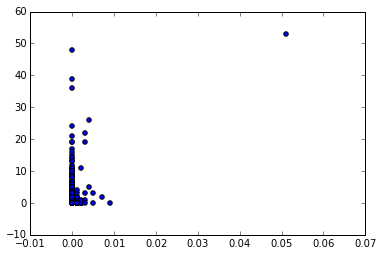

In [89]:
plt.scatter(conflicts.Predicted_Conflicts, conflicts.Observed_MIDs)

In [91]:
conflicts[conflicts.Predicted_Conflicts<50].corr()

,Predicted_Conflicts,Observed_MIDs,Const.
Predicted_Conflicts,1.000000,0.442195,NaN
Observed_MIDs,0.442195,1.000000,NaN
Const.,NaN,NaN,NaN


In [92]:
conflicts.corr()

,Predicted_Conflicts,Observed_MIDs,Const.
Predicted_Conflicts,1.000000,0.442195,NaN
Observed_MIDs,0.442195,1.000000,NaN
Const.,NaN,NaN,NaN


In [90]:
conflicts["Const."] = 1

In [74]:
conflicts[conflicts.Predicted_Conflicts>20/1000]

,Source_Country,Target_Country,Predicted_Conflicts,Observed_MIDs,Const.,MID_Dummy,PredictedConflicts_Dummy


In [75]:
#conflicts = conflicts[conflicts.Predicted_Conflicts < 50]

In [106]:
lm = sm.OLS(conflicts.Observed_MIDs, conflicts[["Const.", "Predicted_Conflicts"]])
fit = lm.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:          Observed_MIDs   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     620.8
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          7.65e-123
Time:                        09:08:57   Log-Likelihood:                -5645.1
No. Observations:                2556   AIC:                         1.129e+04
Df Residuals:                    2554   BIC:                         1.131e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Const.                  0.3621    

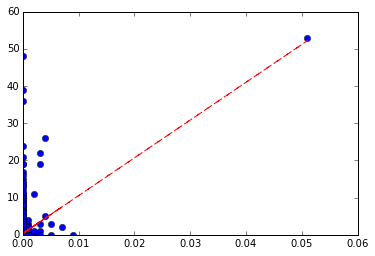

In [107]:
fig, ax = plt.subplots()
plt.plot(conflicts.Predicted_Conflicts, conflicts.Observed_MIDs, 'o')
plt.plot(conflicts.Predicted_Conflicts, fit.fittedvalues, 'r--')

In [108]:
conflicts.to_csv("transfer/conflict_df_ex4.csv")

In [94]:
with open("lm_ex_4.pickle", "wb") as f:
    pickle.dump(fit, f)

In [95]:
conflicts["MID_Dummy"] = 0
conflicts["MID_Dummy"][conflicts.Observed_MIDs > 0] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [102]:
logit = sm.Logit(conflicts.MID_Dummy, conflicts[["Const.", "Predicted_Conflicts"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.329274
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              MID_Dummy   No. Observations:                 2556
Model:                          Logit   Df Residuals:                     2554
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Dec 2015   Pseudo R-squ.:                 0.01643
Time:                        15:32:30   Log-Likelihood:                -841.62
converged:                       True   LL-Null:                       -855.68
                                        LLR p-value:                 1.143e-07
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Const.                 -2.1966      0.066    -33.158      0.000        -2.326    -2.067
Pr

In [103]:
with open("logit_ex_4.pickle", "wb") as f:
    pickle.dump(fit, f)

In [98]:
conflicts["PredictedConflicts_Dummy"] = 0
conflicts["PredictedConflicts_Dummy"][conflicts.Predicted_Conflicts>0] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [99]:
logit = sm.Logit(conflicts.MID_Dummy, conflicts[["Const.", "PredictedConflicts_Dummy"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.329670
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              MID_Dummy   No. Observations:                 2556
Model:                          Logit   Df Residuals:                     2554
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Dec 2015   Pseudo R-squ.:                 0.01524
Time:                        15:27:30   Log-Likelihood:                -842.64
converged:                       True   LL-Null:                       -855.68
                                        LLR p-value:                 3.262e-07
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Const.                      -2.2129      0.067    -32.953      0.000        -2.3

# Top conflict dyads

In [104]:
conflict_pairs = conflicts[["Source_Country", "Target_Country", 
                            "Predicted_Conflicts", "Observed_MIDs"]].copy()

In [105]:
conflict_pairs.sort("Predicted_Conflicts", ascending=False).head(10)

,Source_Country,Target_Country,Predicted_Conflicts,Observed_MIDs
2433,United States of America,Russia,0.051,53
2443,United States of America,United Kingdom,0.009,0
1885,Russia,Argentina,0.007,2
2406,United States of America,India,0.005,0
2447,United States of America,Yugoslavia,0.005,3
2387,United States of America,China,0.004,26
2391,United States of America,Czechoslovakia,0.004,5
452,China,France,0.003,3
2431,United States of America,Portugal,0.003,0
2430,United States of America,Poland,0.003,1
